## sigMF RF classification; 12 classes

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
compare = .5
r1_c2 = 1
r2_c2 = 10e1
top = .99
var_noise = 8.78e-09
# mean_noise = 10 # worked pretty good
mean_noise = 1
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
batches = 64
plt.style.use('default')
GPU = 0
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [2]:
r2_c2

100.0

In [3]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths

In [4]:
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
path = "/home/david/sigMF_ML/RF/RF_class/data/" # ACE
path_val1 = "/home/david/sigMF_ML/RF/RF_class/data_val1/" # fft_center    - class 9
path_val2 = "/home/david/sigMF_ML/RF/RF_class/data_val2/" # light switch - class 10
path_val3 = "/home/david/sigMF_ML/RF/RF_class/data_val3/" # clickndig     - class 5
path_val4 = "/home/david/sigMF_ML/RF/RF_class/data_val4/" # GD55          - class 1
path_val5 = "/home/david/sigMF_ML/RF/RF_class/data_val5/" # lora125       - class 0
path_val6 = "/home/david/sigMF_ML/RF/RF_class/data_val6/" # lora250       - class 7
path_val7 = "/home/david/sigMF_ML/RF/RF_class/data_val7/" # NFM           - class 2
path_val8 = "/home/david/sigMF_ML/RF/RF_class/data_val8/" # sado          - class 6
path_val9 = "/home/david/sigMF_ML/RF/RF_class/data_val9/" # TYT           - class 3
path_val10 = "/home/david/sigMF_ML/RF/RF_class/data_val10/" # vodeson     - class 4
path_val11 = "/home/david/sigMF_ML/RF/RF_class/data_val11/" # white noise - class 8
path_val12 = "/home/david/sigMF_ML/RF/RF_class/data_val12/" # ysf        - class 11
path_fig = "/home/david/sigMF_ML/RF/RF_class/figures/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
print(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [5]:
print(path_test)

os.chdir(path_test)
data_files_test = sorted(glob.glob('*.sigmf-data'))
meta_files_test = sorted(glob.glob('*.sigmf-meta'))

/home/david/sigMF_ML/RF/RF_class/testing_data/


## Functions 

In [6]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model():
    rf_model = 'ResNet50_v60_20210221_plot_4D_10dB_autosave'
    PATH = path_save+rf_model
    torch.save(model.state_dict(), PATH)
    
# def load_model():
#     rf_model = 'ResNet50_v58_20210214_4D_10_autosave'
#     PATH = path_save+rf_model
#     device = torch.device("cuda:0")
# #     model = resnet50(4, 12)
#     model.load_state_dict(torch.load(PATH))
#     model.to(device)
#     model.eval() 
#     return model

def load_model(rf_model):
#     rf_model = 'ResNet50_v58_20210212_4D_autosave'
    PATH = path_save+rf_model
    device = torch.device("cuda:0")
    model = resnet50(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()
    return model



def gpu_test_file(db,msps):
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps
    elif (msps == 25):
        w1 = fft*msps
    print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    print('window length = ', w1)
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     print('X shape =', X_stft.shape)
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test Z shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    print('Final gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[:w//2,:,:] # throw bottom 1/2 away
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D

def gpu_test_live(db,msps):
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]      
    print('gpu_test live function')    
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps
    elif (msps == 25):
        w1 = fft*msps     
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test live IQ shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D and plot

def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files,msps): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live: remarked out plotting')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_live(db,msps)
        # *************************************************************************
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))       
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

In [7]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [8]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [10]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [11]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [12]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [13]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [14]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [15]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [16]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [17]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [19]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [20]:
from torch.utils.data import Dataset

In [21]:
class RFDataset(Dataset):
    def __init__(self, root_path):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7]
        label = self.get_class[foldername]

        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': label}

#### Evaluation dataset loader

In [22]:
rf_dataset1 = RFDataset(path_val1)
val1_data = data.DataLoader(rf_dataset1, batch_size=batches, shuffle=True)
rf_dataset2 = RFDataset(path_val2)
val2_data = data.DataLoader(rf_dataset2, batch_size=batches, shuffle=True)
rf_dataset3 = RFDataset(path_val3)
val3_data = data.DataLoader(rf_dataset3, batch_size=batches, shuffle=True)
rf_dataset4 = RFDataset(path_val4)
val4_data = data.DataLoader(rf_dataset4, batch_size=batches, shuffle=True)
rf_dataset5 = RFDataset(path_val5)
val5_data = data.DataLoader(rf_dataset5, batch_size=batches, shuffle=True)
rf_dataset6 = RFDataset(path_val6)
val6_data = data.DataLoader(rf_dataset6, batch_size=batches, shuffle=True)
rf_dataset7 = RFDataset(path_val7)
val7_data = data.DataLoader(rf_dataset7, batch_size=batches, shuffle=True)
rf_dataset8 = RFDataset(path_val8)
val8_data = data.DataLoader(rf_dataset8, batch_size=batches, shuffle=True)
rf_dataset9 = RFDataset(path_val9)
val9_data = data.DataLoader(rf_dataset9, batch_size=batches, shuffle=True)
rf_dataset10 = RFDataset(path_val10)
val10_data = data.DataLoader(rf_dataset10, batch_size=batches, shuffle=True)
rf_dataset11 = RFDataset(path_val11)
val11_data = data.DataLoader(rf_dataset11, batch_size=batches, shuffle=True)
rf_dataset12 = RFDataset(path_val12)
val12_data = data.DataLoader(rf_dataset12, batch_size=batches, shuffle=True)

/home/david/sigMF_ML/RF/RF_class/data_val1/
/home/david/sigMF_ML/RF/RF_class/data_val2/
/home/david/sigMF_ML/RF/RF_class/data_val3/
/home/david/sigMF_ML/RF/RF_class/data_val4/
/home/david/sigMF_ML/RF/RF_class/data_val5/
/home/david/sigMF_ML/RF/RF_class/data_val6/
/home/david/sigMF_ML/RF/RF_class/data_val7/
/home/david/sigMF_ML/RF/RF_class/data_val8/
/home/david/sigMF_ML/RF/RF_class/data_val9/
/home/david/sigMF_ML/RF/RF_class/data_val10/
/home/david/sigMF_ML/RF/RF_class/data_val11/
/home/david/sigMF_ML/RF/RF_class/data_val12/


#### list of loaders

In [23]:
val_data_list = [val1_data]
val_data_list.append(val2_data)
val_data_list.append(val3_data)
val_data_list.append(val4_data)
val_data_list.append(val5_data)
val_data_list.append(val6_data)
val_data_list.append(val7_data)
val_data_list.append(val8_data)
val_data_list.append(val9_data)
val_data_list.append(val10_data)
val_data_list.append(val11_data)
val_data_list.append(val12_data)
print('done')

done


## Training

In [24]:
def train_net(total):
    test_patch_total = 24000 # 120000
    compare = .7
    loss_plot = np.zeros(total)
    total_plot = np.zeros(total//5+1)
    batch_plot = np.zeros(len(training_data)*total//100)
    batch_indexer = 0
    for epoch in tqdm(range(total), desc="Epoch"): 
        model.train()
        for i, rf_data in enumerate(training_data, 0):
            start = timer()
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
#             print('input1  = ', inputs.shape)
            inputs = inputs.permute(0,3,1,2).contiguous()
#             print('input out  = ', inputs.shape)
            batch_dim, b, c, d = inputs.shape
            # add som noise
            c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            inputs = inputs + (((var_noise*c2)**0.5)*torch.randn(batch_dim, 4, 224, 224)*1)   
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            end = timer()
            batch_time = end - start
            #***************************************************************************************
            if (i+1) % 100 == 0:
                print('batch time = ', batch_time)
                print('************************* start *************************')
                total_correct_patches = grand_total = 0
                start_test = timer()
                model.eval()
                for testing in val_data_list:
                    t = train_val(testing)
                    total_correct_patches = total_correct_patches + t           
                grand_total = total_correct_patches/test_patch_total
                batch_plot[batch_indexer] = grand_total*100
                batch_indexer = batch_indexer + 1
                print('Batch number = ', i, 'of', len(training_data))
                print('Total % correct {:.2f}%'.format(grand_total*100))         
                model.train 
                end_test = timer()
                test_time = end_test - start_test
                print('test time = ', test_time)
                print('*************************** end ***************************')
                if grand_total > compare:
                    save_model()
                    compare = grand_total
                if grand_total > top:
                    break
            #****************************************************************************************          
            # print statistics
    #     if (epoch+1) % 10 == 0:
        tqdm.write('___________________________________________')
        tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
        tqdm.write('___________________________________________')
        loss_plot[epoch] = loss.data
        if grand_total > top:
            break
    return loss_plot, batch_plot

#### Training Evaluation

In [25]:
def train_val(val_data):
    with torch.no_grad():
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        for i, rf_data in enumerate(val_data, 0): 
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous() 
            batch_dim, b, c, d = inputs.shape
            # add som noise
            c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            inputs = inputs + (((var_noise*c2)**0.5)*torch.randn(batch_dim, 4, 224, 224)*1)
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            optimizer.zero_grad() 
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            for b in range(len(predicted)):
                labels_temp = labels[b].detach().cpu().numpy()
                temp = predicted[b].detach().cpu().numpy()
                if (labels_temp==temp):
                    accumulated_corrects = accumulated_corrects+1
    torch.cuda.empty_cache()
    return accumulated_corrects

## Inference Segmented Dataloader

In [26]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [27]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # uses a LOT of memory for more than 1 25MSPS STFT
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [28]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [29]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

#### Changed to get test data from different directory

In [30]:
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [31]:
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [32]:
def score_IQ_data_one_file_at_a_time_original(center_freq_file, list_of_IQ_data, list_of_labels):    
    with torch.no_grad():
        model.eval()
        start_frequency = (center_freq_file)
        print('start_frequency = ', start_frequency/1000000)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        for data in list_of_IQ_data:
            # shape of "data" should be (513, 1900000000) 
            freq_offset = 0
            match_freq = start_frequency
            histogram = np.zeros(12)

            # chop "data" into the required squares
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)            
            # loop through each square  in list_of_squares and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            count_noise = 0
            count_center = 0
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU
                predicted_class = int(torch.argmax(model(patch))) # gets the index of the largest probability
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
                histogram_frequency[j] = match_freq/1000000
            # print statistics
            histo_stats_freq_file(histogram_frequency, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom*100))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom*100))
                print('NFM = {:.2f}%'.format(histogram[2]/denom*100))
                print('TYT = {:.2f}'.format(histogram[3]/denom*100))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom*100))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom*100))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom*100))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom*100))
                print('light switch = {:.2f}%'.format(histogram[10]/denom*100))
                print('YSF = {:.2f}%'.format(histogram[11]/denom*100))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
    return histogram_global

In [33]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0 
        
        
        
        
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#                 print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this ********************* <-----
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#*************************************************************************************
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
#                 print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
#                 print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
#                 print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
#                 print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [34]:
def score_IQ_data_files(center_freq_file, list_of_IQ_data, list_of_labels,load_net):    
    with torch.no_grad():
        model = load_model(load_net)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        histogram_data = np.zeros((10,10))
        h = 0
        for data in list_of_IQ_data:
            histogram = np.zeros(12)
            # chop "data" into the required patch size
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)   
#***************************************************************************************************************                        
            start_frequency = (center_freq_file)
            match_freq = start_frequency   
            print('start_frequency = ', start_frequency/1000000)           
            # loop through each square  in list_of_patches and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            print('patch total = ', denom)
            count_noise = 0
            count_center = 0
            freq_histo = np.zeros(len(list_of_patches))
            freq_count = 0 # keep track of array position
            freq_offset = 0
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU     
                outputs = model(patch)
                predicted_class = int(torch.argmax(outputs.data))
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
#*******************************************************************************   
                if (predicted_class == 0):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 1):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 2):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 3):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 4):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 5):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 6):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 7):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 10):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 11):
                    freq_histo[j] = match_freq/1000000                   
#******************************************************************************
                histogram_frequency[j] = match_freq/1000000
                freq_offset = freq_offset + 1
                if (freq_offset == seg_freq):
                    freq_offset = 0
                match_freq = start_frequency                
            # print statistics
            denom = denom - count_noise - count_center
            histo_stats_freq_file(freq_histo, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom))
                print('NFM = {:.2f}%'.format(histogram[2]/denom))
                print('TYT = {:.2f}'.format(histogram[3]/denom))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom))
                print('light switch = {:.2f}%'.format(histogram[10]/denom))
                print('YSF = {:.2f}%'.format(histogram[11]/denom))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
            histogram_data[h,0] = histogram[0]/denom
            histogram_data[h,1] = histogram[1]/denom
            histogram_data[h,2] = histogram[2]/denom
            histogram_data[h,3] = histogram[3]/denom
            histogram_data[h,4] = histogram[4]/denom
            histogram_data[h,5] = histogram[5]/denom
            histogram_data[h,6] = histogram[6]/denom
            histogram_data[h,7] = histogram[7]/denom
            histogram_data[h,8] = histogram[10]/denom   
            histogram_data[h,9] = histogram[11]/denom                       
            h = h + 1
    return histogram_global, histogram_data

In [35]:
    # inference ************************************************************
def testing_live(msps,load_net): 
        model = load_model(load_net)
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented_live(), batch_size=1)
        start_frequency = (center_freq_live)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
                print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
                stft_plot = np.squeeze(inputs, axis=0)
                fig=plt.figure(figsize=(8,8))
                ncols = 5
                nrows = 5
                range_plot = 1
                range_end = range_plot+5
                for x in range(1,51): # need to figure out how to not hard code this ********************* <-----
                    if (x>=range_plot and x<(range_end)):
                        stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
                        stft_plot1 = np.squeeze(stft_plot1, axis=0)
                        fig.add_subplot(nrows, ncols, x-range_plot+1)
                        plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_end)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#                         print('******************')                
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_live(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [36]:
train_dataloader = RFDataset(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [37]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

## CUDA initialization

In [38]:
# model = resnet50(4, 12) # number of input channels, number of classes
# model = load_model()
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
# CUDA  
# model = load_model()

In [39]:
torch.cuda.empty_cache()

## Final training initialization

In [40]:
# momentum = .3
criterion = nn.CrossEntropyLoss()
lr= .1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.RMSprop(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.SGD(model.parameters(), lr=lr)
# training_data = data.DataLoader(rf_dataset, batch_size=batches, shuffle=True)
model.train()

NameError: name 'model' is not defined

In [41]:
# VALIDATION ************************************************************
np.set_printoptions(threshold=np.inf)
calc = np.zeros([6])
averaging = 0
correct = 0
total = 0
V = data.DataLoader(inference_dataloader_segmented(), batch_size=1, shuffle=True)
model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### TRAIN Model

In [57]:
total = 50
loss_plot,total_plot = train_net(total)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

batch time =  0.4262889709789306
************************* start *************************
Batch number =  99 of 1913
Total % correct 35.63%
test time =  95.13130274810828
*************************** end ***************************
batch time =  0.41503080702386796
************************* start *************************
Batch number =  199 of 1913
Total % correct 59.06%
test time =  92.36626973887905
*************************** end ***************************
batch time =  0.4754716739989817
************************* start *************************
Batch number =  299 of 1913
Total % correct 66.12%
test time =  96.70279525709338
*************************** end ***************************
batch time =  0.4870111548807472
************************* start *************************
Batch number =  399 of 1913
Total % correct 71.11%
test time =  98.61646907194518
*************************** end ***************************
batch time =  0.4185824340675026
************************* start ***

Epoch:   2%|▏         | 1/50 [46:22<37:52:28, 2782.63s/it]

___________________________________________
Epoch 1 Loss 0.0983010456 
___________________________________________
batch time =  0.4785625447984785
************************* start *************************
Batch number =  99 of 1913
Total % correct 59.48%
test time =  98.07916026492603
*************************** end ***************************
batch time =  0.4319994121324271
************************* start *************************
Batch number =  199 of 1913
Total % correct 79.80%
test time =  98.8803603539709
*************************** end ***************************
batch time =  0.4234506820794195
************************* start *************************
Batch number =  299 of 1913
Total % correct 84.52%
test time =  98.65016630711034
*************************** end ***************************
batch time =  0.431988432072103
************************* start *************************
Batch number =  399 of 1913
Total % correct 91.30%
test time =  98.62282971804962
****************

Epoch:   4%|▍         | 2/50 [1:32:59<37:09:36, 2787.01s/it]

___________________________________________
Epoch 2 Loss 0.1298285127 
___________________________________________
batch time =  0.44404410291463137
************************* start *************************
Batch number =  99 of 1913
Total % correct 78.99%
test time =  97.88069697609171
*************************** end ***************************
batch time =  0.4401266018394381
************************* start *************************
Batch number =  199 of 1913
Total % correct 90.34%
test time =  98.62619485310279
*************************** end ***************************
batch time =  0.42706521903164685
************************* start *************************
Batch number =  299 of 1913
Total % correct 92.12%
test time =  99.41483379504643
*************************** end ***************************
batch time =  0.4286592740099877
************************* start *************************
Batch number =  399 of 1913
Total % correct 92.58%
test time =  98.78640566812828
************

Epoch:   6%|▌         | 3/50 [2:19:38<36:25:56, 2790.57s/it]

___________________________________________
Epoch 3 Loss 0.0485788882 
___________________________________________
batch time =  0.44017109903506935
************************* start *************************
Batch number =  99 of 1913
Total % correct 91.30%
test time =  99.06811806815676
*************************** end ***************************
batch time =  0.4252028251066804
************************* start *************************
Batch number =  199 of 1913
Total % correct 93.65%
test time =  97.75577337201685
*************************** end ***************************
batch time =  0.43188036512583494
************************* start *************************
Batch number =  299 of 1913
Total % correct 94.87%
test time =  98.1370149969589
*************************** end ***************************
batch time =  0.4311440968886018
************************* start *************************
Batch number =  399 of 1913
Total % correct 95.28%
test time =  99.2151157350745
**************

Epoch:   8%|▊         | 4/50 [3:06:01<35:37:37, 2788.21s/it]

___________________________________________
Epoch 4 Loss 0.0214480702 
___________________________________________
batch time =  0.4797806900460273
************************* start *************************
Batch number =  99 of 1913
Total % correct 90.21%
test time =  94.61222613812424
*************************** end ***************************
batch time =  0.41872085095383227
************************* start *************************
Batch number =  199 of 1913
Total % correct 95.33%
test time =  95.1554380399175
*************************** end ***************************
batch time =  0.4650510558858514
************************* start *************************
Batch number =  299 of 1913
Total % correct 96.28%
test time =  95.34075193409808
*************************** end ***************************
batch time =  0.41446377616375685
************************* start *************************
Batch number =  399 of 1913
Total % correct 94.33%
test time =  94.67744878912345
*************

Epoch:  10%|█         | 5/50 [3:51:06<34:32:20, 2763.13s/it]

___________________________________________
Epoch 5 Loss 0.0021123488 
___________________________________________
batch time =  0.4391859311144799
************************* start *************************
Batch number =  99 of 1913
Total % correct 92.97%
test time =  95.4322531670332
*************************** end ***************************
batch time =  0.40809484710916877
************************* start *************************
Batch number =  199 of 1913
Total % correct 94.31%
test time =  95.0822181829717
*************************** end ***************************
batch time =  0.44236739492043853
************************* start *************************
Batch number =  299 of 1913
Total % correct 94.99%
test time =  95.25598837994039
*************************** end ***************************
batch time =  0.4206034541130066
************************* start *************************
Batch number =  399 of 1913
Total % correct 95.51%
test time =  95.65324263297953
**************

Epoch:  12%|█▏        | 6/50 [4:36:10<33:33:28, 2745.64s/it]

___________________________________________
Epoch 6 Loss 0.0477627926 
___________________________________________
batch time =  0.4281957389321178
************************* start *************************
Batch number =  99 of 1913
Total % correct 94.39%
test time =  95.67944860109128
*************************** end ***************************
batch time =  0.42261991114355624
************************* start *************************
Batch number =  199 of 1913
Total % correct 95.62%
test time =  94.97729553608224
*************************** end ***************************
batch time =  0.4199757550377399
************************* start *************************
Batch number =  299 of 1913
Total % correct 96.03%
test time =  95.2749904259108
*************************** end ***************************
batch time =  0.4442649579141289
************************* start *************************
Batch number =  399 of 1913
Total % correct 95.42%
test time =  95.46244678203948
**************

Epoch:  14%|█▍        | 7/50 [5:21:15<32:38:48, 2733.23s/it]

___________________________________________
Epoch 7 Loss 0.0424207039 
___________________________________________
batch time =  0.4637740489561111
************************* start *************************
Batch number =  99 of 1913
Total % correct 94.78%
test time =  94.87831071508117
*************************** end ***************************
batch time =  0.42440118291415274
************************* start *************************
Batch number =  199 of 1913
Total % correct 95.17%
test time =  95.35538887209259
*************************** end ***************************
batch time =  0.4098264630883932
************************* start *************************
Batch number =  299 of 1913
Total % correct 94.55%
test time =  95.02108148112893
*************************** end ***************************
batch time =  0.4325259409379214
************************* start *************************
Batch number =  399 of 1913
Total % correct 96.25%
test time =  95.17153926403262
*************

Epoch:  16%|█▌        | 8/50 [6:06:20<31:47:24, 2724.87s/it]

___________________________________________
Epoch 8 Loss 0.0050206366 
___________________________________________
batch time =  0.4520871671847999
************************* start *************************
Batch number =  99 of 1913
Total % correct 94.45%
test time =  95.46164747606963
*************************** end ***************************
batch time =  0.4228670750744641
************************* start *************************
Batch number =  199 of 1913
Total % correct 97.32%
test time =  94.25489154597744
*************************** end ***************************
batch time =  0.41351867211051285
************************* start *************************
Batch number =  299 of 1913
Total % correct 95.89%
test time =  95.27705533592962
*************************** end ***************************
batch time =  0.4550050348043442
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.31%
test time =  94.33646770985797
*************

Epoch:  18%|█▊        | 9/50 [6:51:25<30:57:51, 2718.82s/it]

___________________________________________
Epoch 9 Loss 0.0030586461 
___________________________________________
batch time =  0.4381827299948782
************************* start *************************
Batch number =  99 of 1913
Total % correct 94.74%
test time =  94.62977521284483
*************************** end ***************************
batch time =  0.4241060549393296
************************* start *************************
Batch number =  199 of 1913
Total % correct 96.18%
test time =  94.73829274601303
*************************** end ***************************
batch time =  0.4172108650673181
************************* start *************************
Batch number =  299 of 1913
Total % correct 95.89%
test time =  94.99870744301006
*************************** end ***************************
batch time =  0.41707766498439014
************************* start *************************
Batch number =  399 of 1913
Total % correct 96.83%
test time =  94.73525312310085
*************

Epoch:  20%|██        | 10/50 [7:36:27<30:09:17, 2713.93s/it]

___________________________________________
Epoch 10 Loss 0.0002018255 
___________________________________________
batch time =  0.4346248088404536
************************* start *************************
Batch number =  99 of 1913
Total % correct 95.53%
test time =  94.64770938991569
*************************** end ***************************
batch time =  0.4190567808691412
************************* start *************************
Batch number =  199 of 1913
Total % correct 96.99%
test time =  94.32056688796729
*************************** end ***************************
batch time =  0.4195857581216842
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.25%
test time =  94.71621864615008
*************************** end ***************************
batch time =  0.4232173669151962
************************* start *************************
Batch number =  399 of 1913
Total % correct 96.60%
test time =  95.31472286907956
*************

Epoch:  22%|██▏       | 11/50 [8:21:32<29:22:20, 2711.29s/it]

___________________________________________
Epoch 11 Loss 0.0048096287 
___________________________________________
batch time =  0.42227671504952013
************************* start *************************
Batch number =  99 of 1913
Total % correct 97.35%
test time =  94.70177360693924
*************************** end ***************************
batch time =  0.4330287140328437
************************* start *************************
Batch number =  199 of 1913
Total % correct 97.21%
test time =  97.6220170930028
*************************** end ***************************
batch time =  0.42311074887402356
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.65%
test time =  97.7957618269138
*************************** end ***************************
batch time =  0.42596282507292926
************************* start *************************
Batch number =  399 of 1913
Total % correct 95.10%
test time =  97.73101850505918
************

Epoch:  24%|██▍       | 12/50 [9:07:21<28:44:11, 2722.40s/it]

___________________________________________
Epoch 12 Loss 0.0018687457 
___________________________________________
batch time =  0.43927875300869346
************************* start *************************
Batch number =  99 of 1913
Total % correct 96.55%
test time =  96.56391129689291
*************************** end ***************************
batch time =  0.41739684203639627
************************* start *************************
Batch number =  199 of 1913
Total % correct 96.45%
test time =  96.43683742498979
*************************** end ***************************
batch time =  0.4137364758644253
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.42%
test time =  96.12926738988608
*************************** end ***************************
batch time =  0.42757944902405143
************************* start *************************
Batch number =  399 of 1913
Total % correct 95.18%
test time =  96.60760012711398
**********

Epoch:  26%|██▌       | 13/50 [9:53:02<28:02:16, 2728.02s/it]

___________________________________________
Epoch 13 Loss 0.0009725483 
___________________________________________
batch time =  0.4397469130344689
************************* start *************************
Batch number =  99 of 1913
Total % correct 95.82%
test time =  97.05132219404913
*************************** end ***************************
batch time =  0.4218191399704665
************************* start *************************
Batch number =  199 of 1913
Total % correct 96.97%
test time =  95.98795532481745
*************************** end ***************************
batch time =  0.42652533994987607
************************* start *************************
Batch number =  299 of 1913
Total % correct 96.28%
test time =  96.77615078398958
*************************** end ***************************
batch time =  0.4186973699834198
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.12%
test time =  96.40478922007605
************

Epoch:  28%|██▊       | 14/50 [10:38:42<27:19:03, 2731.76s/it]

___________________________________________
Epoch 14 Loss 0.0017949510 
___________________________________________
batch time =  0.4599272049963474
************************* start *************************
Batch number =  99 of 1913
Total % correct 92.09%
test time =  96.57326623494737
*************************** end ***************************
batch time =  0.4255236987955868
************************* start *************************
Batch number =  199 of 1913
Total % correct 96.37%
test time =  96.7493453361094
*************************** end ***************************
batch time =  0.4268692850600928
************************* start *************************
Batch number =  299 of 1913
Total % correct 95.80%
test time =  96.68305844487622
*************************** end ***************************
batch time =  0.4451700549107045
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.64%
test time =  96.50734790298156
**************

Epoch:  30%|███       | 15/50 [11:24:24<26:35:18, 2734.82s/it]

___________________________________________
Epoch 15 Loss 0.0041745594 
___________________________________________
batch time =  0.44601148716174066
************************* start *************************
Batch number =  99 of 1913
Total % correct 96.19%
test time =  96.8021462878678
*************************** end ***************************
batch time =  0.4155343270394951
************************* start *************************
Batch number =  199 of 1913
Total % correct 97.57%
test time =  96.55448828218505
*************************** end ***************************
batch time =  0.4142799258697778
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.45%
test time =  96.60350747895427
*************************** end ***************************
batch time =  0.42009307513944805
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.46%
test time =  96.33305396395735
************

Epoch:  32%|███▏      | 16/50 [12:10:08<25:51:11, 2737.38s/it]

___________________________________________
Epoch 16 Loss 0.0016177357 
___________________________________________
batch time =  0.44304237188771367
************************* start *************************
Batch number =  99 of 1913
Total % correct 95.89%
test time =  96.42785207205452
*************************** end ***************************
batch time =  0.44493666919879615
************************* start *************************
Batch number =  199 of 1913
Total % correct 96.96%
test time =  96.4530367788393
*************************** end ***************************
batch time =  0.4360902030020952
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.47%
test time =  96.54118431708775
*************************** end ***************************
batch time =  0.41081427480094135
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.28%
test time =  96.56691233697347
***********

Epoch:  34%|███▍      | 17/50 [12:55:51<25:06:28, 2739.06s/it]

___________________________________________
Epoch 17 Loss 0.0010024840 
___________________________________________
batch time =  0.43947923788800836
************************* start *************************
Batch number =  99 of 1913
Total % correct 98.18%
test time =  97.28699710499495
*************************** end ***************************
batch time =  0.4296315668616444
************************* start *************************
Batch number =  199 of 1913
Total % correct 97.87%
test time =  96.68303151102737
*************************** end ***************************
batch time =  0.4539133079815656
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.29%
test time =  96.6624236300122
*************************** end ***************************
batch time =  0.4193439029622823
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.50%
test time =  96.84551638411358
*************

Epoch:  36%|███▌      | 18/50 [13:41:34<24:21:28, 2740.26s/it]

___________________________________________
Epoch 18 Loss 0.1393011957 
___________________________________________
batch time =  0.47975294291973114
************************* start *************************
Batch number =  99 of 1913
Total % correct 97.58%
test time =  96.76411156798713
*************************** end ***************************
batch time =  0.4219590900465846
************************* start *************************
Batch number =  199 of 1913
Total % correct 95.73%
test time =  96.47740199812688
*************************** end ***************************
batch time =  0.4364487158600241
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.80%
test time =  96.73538752319291
*************************** end ***************************
batch time =  0.42889009695500135
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.80%
test time =  96.88971795095131
***********

Epoch:  38%|███▊      | 19/50 [14:27:18<23:36:27, 2741.52s/it]

___________________________________________
Epoch 19 Loss 0.0056703612 
___________________________________________
batch time =  0.4605382711160928
************************* start *************************
Batch number =  99 of 1913
Total % correct 98.63%
test time =  96.75955636613071
*************************** end ***************************
batch time =  0.4280145529191941
************************* start *************************
Batch number =  199 of 1913
Total % correct 97.74%
test time =  96.18583156890236
*************************** end ***************************
batch time =  0.4183343139011413
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.75%
test time =  96.47188159101643
*************************** end ***************************
batch time =  0.43935150699689984
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.55%
test time =  96.41321050096303
************

Epoch:  40%|████      | 20/50 [15:13:02<22:51:09, 2742.31s/it]

___________________________________________
Epoch 20 Loss 0.0019739424 
___________________________________________
batch time =  0.45320109208114445
************************* start *************************
Batch number =  99 of 1913
Total % correct 97.18%
test time =  96.72186854295433
*************************** end ***************************
batch time =  0.4311115809250623
************************* start *************************
Batch number =  199 of 1913
Total % correct 97.84%
test time =  96.44672533101402
*************************** end ***************************
batch time =  0.41155200405046344
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.58%
test time =  96.76228798087686
*************************** end ***************************
batch time =  0.4476414290256798
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.12%
test time =  96.50221961201169
***********

Epoch:  42%|████▏     | 21/50 [15:58:46<22:05:35, 2742.62s/it]

___________________________________________
Epoch 21 Loss 0.0010385348 
___________________________________________
batch time =  0.43751393910497427
************************* start *************************
Batch number =  99 of 1913
Total % correct 97.27%
test time =  97.14147549495101
*************************** end ***************************
batch time =  0.48212655493989587
************************* start *************************
Batch number =  199 of 1913
Total % correct 97.47%
test time =  97.04815180995502
*************************** end ***************************
batch time =  0.43023356911726296
************************* start *************************
Batch number =  299 of 1913
Total % correct 97.79%
test time =  96.51107663009316
*************************** end ***************************
batch time =  0.43785515800118446
************************* start *************************
Batch number =  399 of 1913
Total % correct 94.55%
test time =  96.52016037609428
*********

Epoch:  44%|████▍     | 22/50 [16:44:29<21:20:00, 2742.86s/it]

___________________________________________
Epoch 22 Loss 0.0002810182 
___________________________________________
batch time =  0.43401786615140736
************************* start *************************
Batch number =  99 of 1913
Total % correct 97.64%
test time =  96.97792687406763
*************************** end ***************************
batch time =  0.4282809451688081
************************* start *************************
Batch number =  199 of 1913
Total % correct 98.06%
test time =  96.3225811671
*************************** end ***************************
batch time =  0.4196425040718168
************************* start *************************
Batch number =  299 of 1913
Total % correct 98.22%
test time =  96.97435267502442
*************************** end ***************************
batch time =  0.4355127599555999
************************* start *************************
Batch number =  399 of 1913
Total % correct 97.95%
test time =  96.58529589883983
****************

Epoch:  46%|████▌     | 23/50 [17:30:13<20:34:27, 2743.23s/it]

___________________________________________
Epoch 23 Loss 0.0000086536 
___________________________________________
batch time =  0.44330980791710317
************************* start *************************
Batch number =  99 of 1913
Total % correct 98.31%
test time =  96.85144205205142
*************************** end ***************************
batch time =  0.422489948105067
************************* start *************************
Batch number =  199 of 1913
Total % correct 98.28%
test time =  96.39222730509937
*************************** end ***************************
batch time =  0.4227970859501511
************************* start *************************
Batch number =  299 of 1913
Total % correct 98.60%
test time =  96.58442940097302
*************************** end ***************************
batch time =  0.42174990801140666
************************* start *************************
Batch number =  399 of 1913
Total % correct 98.42%
test time =  96.81747595011257
************

Epoch:  48%|████▊     | 24/50 [18:15:56<19:48:41, 2743.14s/it]

___________________________________________
Epoch 24 Loss 0.0006447980 
___________________________________________
batch time =  0.44516700715757906
************************* start *************************
Batch number =  99 of 1913
Total % correct 96.22%
test time =  96.81486510904506
*************************** end ***************************
batch time =  0.43350182590074837
************************* start *************************
Batch number =  199 of 1913
Total % correct 96.88%
test time =  96.90156651800498
*************************** end ***************************
batch time =  0.4195697770919651
************************* start *************************
Batch number =  299 of 1913
Total % correct 98.30%
test time =  96.32522202003747
*************************** end ***************************
batch time =  0.4180088739376515
************************* start *************************
Batch number =  399 of 1913
Total % correct 98.59%
test time =  96.37899206299335
***********

Epoch:  50%|█████     | 25/50 [19:01:40<19:03:01, 2743.27s/it]

___________________________________________
Epoch 25 Loss 0.0018417955 
___________________________________________
batch time =  0.4297381788492203
************************* start *************************
Batch number =  99 of 1913
Total % correct 98.47%
test time =  96.64135046303272
*************************** end ***************************
batch time =  0.43171320715919137
************************* start *************************
Batch number =  199 of 1913
Total % correct 98.68%
test time =  97.07348939101212
*************************** end ***************************
batch time =  0.42310171108692884
************************* start *************************
Batch number =  299 of 1913
Total % correct 98.04%
test time =  96.45683489693329
*************************** end ***************************
batch time =  0.4244405368808657
************************* start *************************
Batch number =  399 of 1913
Total % correct 98.41%
test time =  96.85581912100315
***********

Epoch:  50%|█████     | 25/50 [19:30:27<19:03:01, 2743.27s/it]

Batch number =  1199 of 1913
Total % correct 99.03%
test time =  96.73513097898103
*************************** end ***************************
___________________________________________
Epoch 26 Loss 0.0010613343 


Epoch:  50%|█████     | 25/50 [19:30:27<19:30:27, 2809.12s/it]

___________________________________________


In [58]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
# num = 20
np.save('resnet50_4D_plot_100vals_rev1', np.asarray(total_plot))
np.save('resnet50_4D_plot_100vals_2_rev1', total_plot) 

In [43]:
os.chdir(path_plot_fig)
resnet50_4D = np.load('resnet18_4D_plot_100vals.npy')
# resnet18_4D = np.load('resnet18_4D_plot.npy')
# vgg16_4D = np.load('vgg16_acc_4D_plot.npy')
# resnet50_acc_2D = np.load('resnet50_2D_plot2.npy')
# resnet50_2D = np.load('resnet18_2D_plot.npy')
# vgg16_2D = np.load('vgg16_2D_plot.npy')

In [61]:
resnet50_4D.shape

NameError: name 'resnet50_4D' is not defined

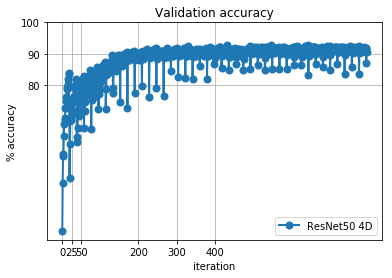

In [46]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
num = 800
x = np.arange(0,num,1) # Start at index position 1
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
plt.plot(x[0:num],resnet50_4D[:num], '-o', c='#1f77b4',markersize=6, linewidth=2,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='ResNet50 4D')
# plt.plot(x[1:num],resnet18_4D[1:num], '-*', c='#ff7f0e',markersize=6, linewidth=2,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=2, label='ResNet18 4D')
# plt.plot(x[1:num],vgg16_4D[1:num], '-X', c='#2ca02c', markersize=6, linewidth=2,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=2, label='VGG16 4D')
# plt.plot(x[1:num],resnet50_2D[1:num], '-D', c='#d62728', markersize=6, linewidth=2,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='ResNet50 2D')
# plt.plot(x[1:num],resnet18_2D[1:num], '-^', c='#9467bd', markersize=6, linewidth=2,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=2, label='ResNet18 2D')
# plt.plot(x[1:num],vgg16_2D[1:num], '-P', c='#8c564b', markersize=6, linewidth=2,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='VGG16 2D')
plt.legend(loc='lower right')
plt.title('Validation accuracy')
plt.xlabel('iteration')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
plt.yticks(np.arange(80,110, 10))
plt.xticks([0, 25, 50, 200, 300, 400])
fig2.savefig('all_network_plots.pdf', format="pdf")
plt.show()

In [96]:
os.chdir(path_plot_fig)
temp = np.load('resnet50_acc_plot2.npy')

In [97]:
temp.shape

(20,)

In [60]:
# ymin = 70
# ymax = 100
# axes = plt.gca()
# # axes.set_xlim([xmin,xmax])
# axes.set_ylim([ymin,ymax])


In [62]:
os.chdir(path_fig)
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.plot(total_plot[:20],c='r', label='Total patches correct')
plt.legend(loc='lower right')
plt.title('Total % correct vs batches')
plt.xlabel('Batch number')
plt.ylabel('% correct')
plt.grid()
fig.savefig('RF_class_resnet50_4D.pdf', format="pdf")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/david/sigMF_ML/RF/RF_class/figures/'

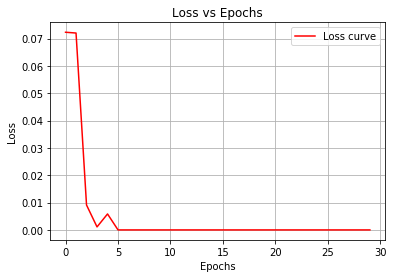

In [45]:
os.chdir(path_fig)
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.plot(loss_plot,c='r', label='Loss curve')
plt.legend(loc='upper right')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
fig.savefig('RF_class_v56_loss_4D.pdf', format="pdf")
plt.show()

#### Testing from saved recording data

### LIVE inferencing

In [138]:
# !python3 /home/david/sigMF_ML/gnuradio/record_live.py

###  TESTING

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 25.000000 MHz... 
[INFO] [B200] Actually got clock rate 25.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
inference file name =  test1.sigmf-meta
iq_read_test live: remarked out plotting
gpu_test live function
25600 MSPS
FINAL gpu_test LIVE IQ shape = torch.Size([12800, 9766, 4])
iq_read_test l

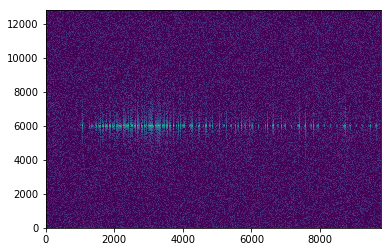

start_frequency =  428.0
sigmf_data =  (12800, 9766, 4)
frequency =  12800   time =  9766
seg_time =  43 seg_freq =  57
data_IQ shape =  (2451, 224, 224, 4)
testing counter =  tensor([2451]) seg_freq = tensor([57])
seg_freq =  tensor([57])


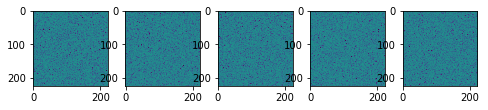

freq_increment =  219298.24561403508
TESTING inputs SHAPE =  torch.Size([1, 2451, 224, 224, 4])
input in   =  torch.Size([1, 2451, 224, 224, 4])
input out  =  torch.Size([2451, 224, 224, 4])
counter convert stuff =  tensor([2451]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([2451, 4, 224, 224])
mean Freq =    432.76
std Freq =      2.19
length of inputs =  2451


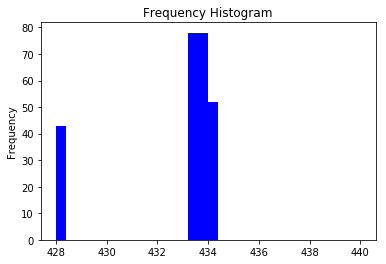

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 16.73%
NFM = 0.00%
TYT = 52.59
Vodeson Doorbell = 0.40%
clickndig = 0.00%
Sado doorbell = 17.53%
LoRa 250 = 0.00%
light switch = 12.75%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2200
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [138]:
msps = 25
center_freq_live = 428.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_25msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 40.000000 MHz... 
[INFO] [B200] Actually got clock rate 40.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
inference file name =  test1.sigmf-meta
iq_read_test live: remarked out plotting
gpu_test live function
Sample Rate =  5120 MSPS
FINAL gpu_test LIVE IQ shape = torch.Size([2560, 9766, 4])
i

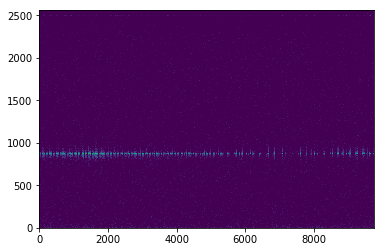

start_frequency =  433.0
sigmf_data =  (2560, 9766, 4)
frequency =  2560   time =  9766
seg_time =  43 seg_freq =  11
data_IQ shape =  (473, 224, 224, 4)
testing counter =  tensor([473]) seg_freq = tensor([11])
seg_freq =  tensor([11])


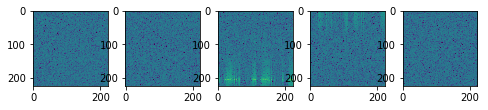

freq_increment =  227272.72727272726
TESTING inputs SHAPE =  torch.Size([1, 473, 224, 224, 4])
input in   =  torch.Size([1, 473, 224, 224, 4])
input out  =  torch.Size([473, 224, 224, 4])
counter convert stuff =  tensor([473]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([473, 4, 224, 224])
mean Freq =    433.68
std Freq =      0.00
length of inputs =  473


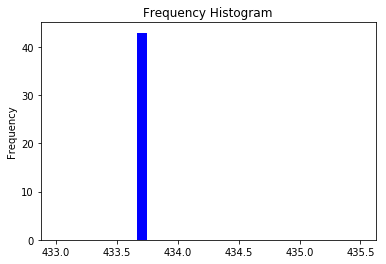

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 2.33%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 97.67%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************


In [152]:
msps = 5
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

#### TESTING Live sample rate differences.

In [39]:
load_net = 'ResNet50_v58_20210214_4D_10_autosave'

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 25.000000 MHz... 
[INFO] [B200] Actually got clock rate 25.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
OOOinference file name =  test1.sigmf-meta
iq_read_test live: remarked out plotting
gpu_test live function
Sample Rate =  1024 MSPS
FINAL gpu_test LIVE IQ shape = torch.Size([512, 9766, 4])

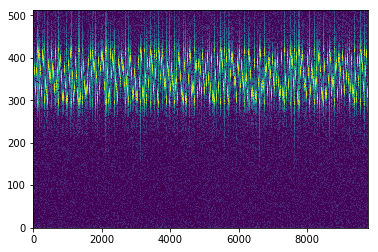

start_frequency =  433.65
sigmf_data =  (512, 9766, 4)
frequency =  512   time =  9766
seg_time =  43 seg_freq =  2
data_IQ shape =  (86, 224, 224, 4)
testing counter =  tensor([86]) seg_freq = tensor([2])
seg_freq =  tensor([2])


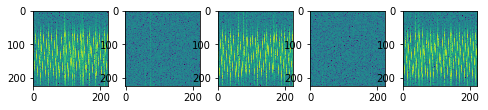

freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 86, 224, 224, 4])
input in   =  torch.Size([1, 86, 224, 224, 4])
input out  =  torch.Size([86, 224, 224, 4])
counter convert stuff =  tensor([86]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([86, 4, 224, 224])
mean Freq =    433.89
std Freq =      0.04
length of inputs =  86


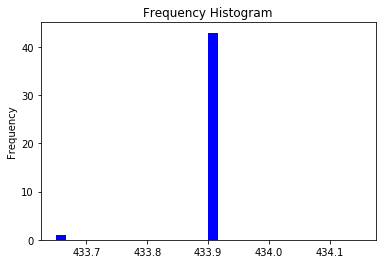

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 97.73%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 2.27
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  42
center fft matches =  0
TOTAL patch count =  86
***************************** Finished *********************************


In [50]:
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# try 25msps decimation to 1msps
!python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps,load_net)
torch.cuda.empty_cache()

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 32.000000 MHz... 
[INFO] [B200] Actually got clock rate 32.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
inference file name =  test1.sigmf-meta
iq_read_test live: remarked out plotting
gpu_test live function
Sample Rate =  1024 MSPS
FINAL gpu_test LIVE IQ shape = torch.Size([512, 9766, 4])
iq

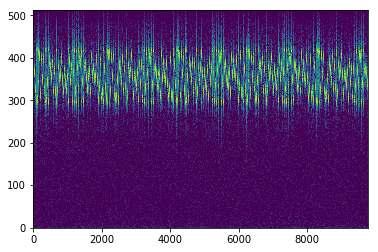

start_frequency =  433.65
sigmf_data =  (512, 9766, 4)
frequency =  512   time =  9766
seg_time =  43 seg_freq =  2
data_IQ shape =  (86, 224, 224, 4)
testing counter =  tensor([86]) seg_freq = tensor([2])
seg_freq =  tensor([2])


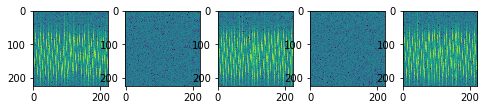

freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 86, 224, 224, 4])
input in   =  torch.Size([1, 86, 224, 224, 4])
input out  =  torch.Size([86, 224, 224, 4])
counter convert stuff =  tensor([86]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([86, 4, 224, 224])
mean Freq =    433.90
std Freq =      0.00
length of inputs =  86


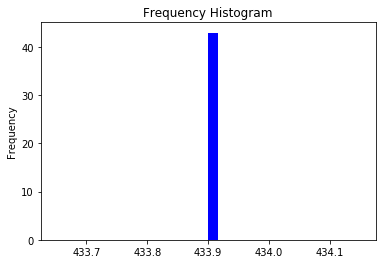

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 100.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  43
center fft matches =  0
TOTAL patch count =  86
***************************** Finished *********************************


In [49]:
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py
!python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps,load_net)
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

In [88]:
# msps = 5
# center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
# testing_file(msps)
# torch.cuda.empty_cache()

inference file name =  UHF_sado_db1_test6.sigmf-meta
iq_read_test file
gpu_test file function
Sample Rate =  25600 MSPS
window length =  1024
Final gpu_test file Z shape = torch.Size([12801, 9766, 4])
imshow method


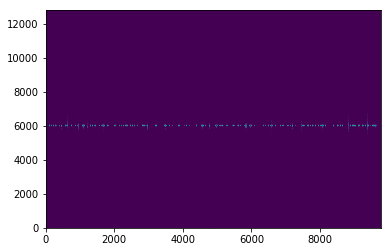

start_frequency =  428.0
sigmf_data =  (12800, 9766, 4)
frequency =  12800   time =  9766
seg_time =  43 seg_freq =  57
data_IQ shape =  (2451, 224, 224, 4)
testing counter =  tensor([2451]) seg_freq = tensor([57])
freq_increment =  219298.24561403508
TESTING inputs SHAPE =  torch.Size([1, 2451, 224, 224, 4])
mean Freq =    433.77
std Freq =      0.10
length of inputs =  2451


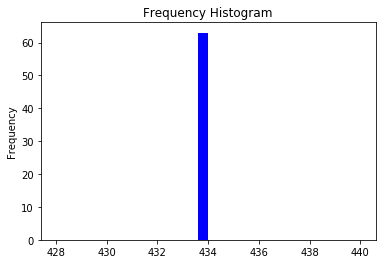

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 31.75
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 68.25%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2388
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [90]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_file(msps)
torch.cuda.empty_cache()

inference file name =  lora125_test1.sigmf-meta
iq_read_test file
gpu_test file function
Sample Rate =  1024 MSPS
window length =  1024
Final gpu_test file Z shape = torch.Size([513, 19532, 4])
imshow method


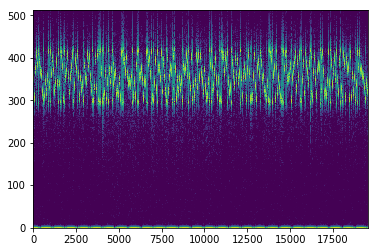

start_frequency =  433.65
sigmf_data =  (512, 19532, 4)
frequency =  512   time =  19532
seg_time =  87 seg_freq =  2
data_IQ shape =  (174, 224, 224, 4)
testing counter =  tensor([174]) seg_freq = tensor([2])
freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 174, 224, 224, 4])
mean Freq =    433.90
std Freq =      0.00
length of inputs =  174


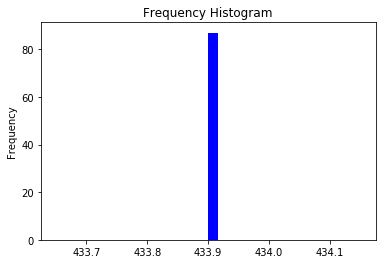

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 100.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  82
center fft matches =  5
TOTAL patch count =  174
***************************** Finished *********************************


In [89]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
testing_file(msps)
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

#### Save and Load model data

In [42]:
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'

In [43]:
# PATH = path_save+rf_model

In [46]:
load_model()

#### save

In [145]:
# torch.save(model.state_dict(), PATH)

#### load

In [44]:
# device = torch.device("cuda:0")
# model = resnet50(4, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [45]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [46]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [47]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [48]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [49]:
# loss

In [50]:
# optimizer_state_dict.keys()